In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [3]:
import pix2tex.cli as cli
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd 
import pickle as pkl
from pix2tex.dataset.dataset import Im2LatexDataset
import yaml
from munch import Munch

/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Replicate eval.py logic

In [28]:
import pix2tex.utils as p2t_utils
import pix2tex.models as p2t_models

CONFIG_PATH = "pix2tex/model/settings/config.yaml"
BATCHSIZE = 1
TEMPERATURE = .9
CHECKPOINT_PATH = "hw_checkpoints/handwritten_training/handwritten_training_e19_step63.pth"
DEVICE = "cpu"
DATA_PATH = "pix2tex/dataset/handwritten/test.pkl"

with open(CONFIG_PATH, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

args = p2t_utils.parse_args(Munch(config))

args.testbatchsize = BATCHSIZE
args.wandb = False
args.temperature = TEMPERATURE

model = p2t_models.get_model(args)
model.load_state_dict(torch.load(CHECKPOINT_PATH, DEVICE))

dataset = Im2LatexDataset(pad=True).load(DATA_PATH)
valargs = args.copy()
valargs.update(batchsize=args.testbatchsize, keep_smaller_batches=True, test=True)
dataset.update(**valargs)

In [45]:
from collections import defaultdict

def evaluate(model, dataset: Im2LatexDataset, args: Munch, num_batches: int = None, name: str = 'test'):
    """evaluates the model. Returns bleu score on the dataset

    Args:
        model (torch.nn.Module): the model
        dataset (Im2LatexDataset): test dataset
        args (Munch): arguments
        num_batches (int): How many batches to evaluate on. Defaults to None (all batches).
        name (str, optional): name of the test e.g. val or test for wandb. Defaults to 'test'.

    Returns:
        Tuple[float, float, float]: BLEU score of validation set, normed edit distance, token accuracy
    """
    assert len(dataset) > 0
    device = args.device
    bleus, edit_dists, token_acc = [], [], []
    bleu_score, edit_distance, token_accuracy = 0, 1, 0
    pbar = tqdm(enumerate(iter(dataset)), total=len(dataset))
    preds = defaultdict(list)
    for i, (seq, im) in pbar:
        if seq is None or im is None:
            continue
        #loss = decoder(tgt_seq, mask=tgt_mask, context=encoded)
        dec = model.generate(im.to(device), temperature=args.get('temperature', .2))
        pred = detokenize(dec, dataset.tokenizer)
        preds[i].append(pred)
        truth = detokenize(seq['input_ids'], dataset.tokenizer)
        bleus.append(metrics.bleu_score(pred, [alternatives(x) for x in truth]))
        for predi, truthi in zip(token2str(dec, dataset.tokenizer), token2str(seq['input_ids'], dataset.tokenizer)):
            ts = post_process(truthi)
            if len(ts) > 0:
                edit_dists.append(distance(post_process(predi), ts)/len(ts))
        dec = dec.cpu()
        tgt_seq = seq['input_ids'][:, 1:]
        shape_diff = dec.shape[1]-tgt_seq.shape[1]
        if shape_diff < 0:
            dec = torch.nn.functional.pad(dec, (0, -shape_diff), "constant", args.pad_token)
        elif shape_diff > 0:
            tgt_seq = torch.nn.functional.pad(tgt_seq, (0, shape_diff), "constant", args.pad_token)
        mask = torch.logical_or(tgt_seq != args.pad_token, dec != args.pad_token)
        tok_acc = (dec == tgt_seq)[mask].float().mean().item()
        token_acc.append(tok_acc)
        pbar.set_description('BLEU: %.3f, ED: %.2e, ACC: %.3f' % (np.mean(bleus), np.mean(edit_dists), np.mean(token_acc)))
        if num_batches is not None and i >= num_batches:
            break
    if len(bleus) > 0:
        bleu_score = np.mean(bleus)
    if len(edit_dists) > 0:
        edit_distance = np.mean(edit_dists)
    if len(token_acc) > 0:
        token_accuracy = np.mean(token_acc)

    print('\n%s\n%s' % (truth, pred))
    print('BLEU: %.2f' % bleu_score)
    return bleu_score, edit_distance, token_accuracy, bleus, edit_dists, token_acc, preds

In [46]:
bleu_score, edit_distance, token_accuracy, bleu_list, edit_dists_list, token_acc_list, preds = evaluate(model, dataset, args)

BLEU: 0.634, ED: 4.00e-01, ACC: 0.585: 100%|██████████| 729/729 [03:22<00:00,  3.60it/s]


[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
BLEU: 0.63


In [48]:
bleu_list

[0.42303482598668557,
 1.0,
 0.9427781105041504,
 0.5923033356666565,
 1.0,
 0.6364716614387282,
 0.8895260095596313,
 1.0,
 0.809106707572937,
 1.0,
 0.41205424070358276,
 1.0,
 1.0,
 0.5521711111068726,
 0.9234732985496521,
 0.15138515830039978,
 1.0,
 0.47252970933914185,
 0.0,
 0.7300205552295784,
 0.6869622917999098,
 1.0,
 1.0,
 0.3368584215641022,
 0.0,
 0.7016116380691528,
 0.2467789500951767,
 0.658854603767395,
 0.4925399720668793,
 0.0,
 0.6017199754714966,
 0.7764520049095154,
 0.2666354289870997,
 1.0,
 1.0,
 0.5328009724617004,
 0.5035338401794434,
 0.0,
 1.0,
 0.773932158946991,
 1.0,
 0.916930079460144,
 0.0,
 1.0,
 1.0,
 1.0,
 0.8895260095596313,
 0.7930231094360352,
 0.7267243773920372,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5231223946970852,
 0.2770519260065613,
 0.7627667783855808,
 0.8818476182028909,
 1.0,
 0.364562340366121,
 1.0,
 0.5706625083643903,
 0.0,
 0.0,
 1.0,
 0.6177712427736617,
 0.0,
 0.6407118077540715,
 0.41374412178993225,
 0.7809325934695621,
 0.6767781376838

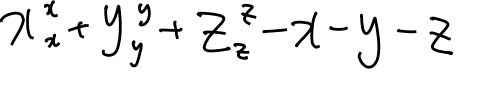

In [43]:
Image.open(dataset.pairs[0][0][1])

In [58]:
np.array(preds[0]).squeeze()

def parse_prediction(pred):
    pred = np.array(pred).squeeze()
    return ''.join(pred)

print(parse_prediction(preds[np.argmax(bleu_list)]))

\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}


$\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}$

# Test with multiline training

In [4]:
import metrics as perf_evaluation

In [5]:
import importlib
importlib.reload(perf_evaluation)

<module 'metrics' from '/Users/juansegundohevia/Documents/repos/TexTract/metrics.py'>

In [6]:
ml_model, ml_dataset_test, args = perf_evaluation.get_model_and_data(config_path="pix2tex/model/settings/multiline_training.yaml",
                                   checkpoint_path="multiline_checkpoints/local_multiline_pix2text/local_multiline_pix2text_e01_step99.pth",
                                   data_path="pix2tex/dataset/multiline/test_300_resized_dataset.pkl",
                                    temperature=.9, batch_size=1, device="mps")

In [7]:
ml_bleu_score, ml_edit_distance, ml_token_accuracy, ml_bleu_list, ml_edit_dists_list, ml_token_acc_list, ml_preds = perf_evaluation.evaluate(ml_model, ml_dataset_test, args)

BLEU: 0.175, ED: 1.53e+00, ACC: 0.056:  98%|█████████▊| 295/300 [1:23:51<01:25, 17.06s/it] 


[['\\', 'dot', '{', 'J', '}', '_', '{', 'i', '}', '=', '-', '\\', 'epsilon', '_', '{', 'm', 'n', 'j', '}', 'J', '_', '{', 'j', '}', '\\', 'frac', '{', '\\', 'partial', 'J', '_', '{', 'i', '}', '}', '{', '\\', 'partial', 'J', '_', '{', 'm', '}', '}', '\\', 'frac', '{', '\\', 'partial', 'T', '}', '{', '\\', 'partial', 'J', '_', '{', 'n', '}', '}', '~', ',', '\\\\', '\\', 'log', 'c', '=', '1', '+', '\\', 'sum', '_', '{', 'k', '>', '1', '}', '{', '\\', 'frac', '{', 'A', '(', 'c', '^', '{', '-', 'k', '}', ')', '}', '{', 'k', '}', '}']]
[['\\', 'J', '_', '{', 'i', '}', '=', '-', 'e', ',', 'm', '_', '{', 'j', '}', '\\', 'frac', '{', '\\', 'mathcal', '{', 'L', '}', '_', '{', 'i', '}', '}', '{', '\\', 'mathcal', '{', 'D', '}', '_', '{', 'm', '}', '}', '\\', 'frac', '{', '\\', 'mathcal', '{', 'D', '}', '_', '{', 'l', '}', '}', '{', '\\', 'mathcal', '{', 'D', '}', '_', '{', 'm', '}', '}', '{', '\\', 'mathcal', '{', 'D', '}', '_', '{', 'n', '}', '}', '\\', 'frac', '{', '\\', 'mathcal', '{', 'D', 

In [8]:
# save output vairables to pickle
with open("notebooks/multiline_performance/ml_output_300.pkl", "wb") as f:
    pkl.dump({
        "bleu_score": ml_bleu_score,
        "edit_distance": ml_edit_distance,
        "token_accuracy": ml_token_accuracy,
        "bleu_list": ml_bleu_list,
        "edit_dists_list": ml_edit_dists_list,
        "token_acc_list": ml_token_acc_list,
        "preds": ml_preds,
        "dataset": ml_dataset_test,
        "args": args,
        "model": ml_model
    }, f)


# Analyze Test Results

In [10]:
with open("notebooks/multiline_performance/ml_output.pkl", "rb") as f:
    results = pkl.load(f)

In [36]:
with open("notebooks/multiline_performance/ml_output-no-finetuning.pkl", "rb") as f:
    results_no_ft = pkl.load(f)

In [11]:
results.keys()

dict_keys(['bleu_score', 'edit_distance', 'token_accuracy', 'bleu_list', 'edit_dists_list', 'token_acc_list', 'preds', 'dataset', 'args'])

In [12]:
# Print scores
print("Multi Line Model Scores")
print("BLEU Score: ", results["bleu_score"])
print("Edit Distance: ", results["edit_distance"])
print("Token Accuracy: ", results["token_accuracy"])

Multi Line Model Scores
BLEU Score:  0.17442291762028722
Edit Distance:  1.6847542807436957
Token Accuracy:  0.05369844352091724


In [37]:
# Print scores
print("Multi Line Model Scores")
print("BLEU Score: ", results_no_ft["bleu_score"])
print("Edit Distance: ", results_no_ft["edit_distance"])
print("Token Accuracy: ", results_no_ft["token_accuracy"])

Multi Line Model Scores
BLEU Score:  0.2831747321765366
Edit Distance:  1.332809210727104
Token Accuracy:  0.062485670852169516


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
pd.Series(results["edit_dists_list"]).describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    976.000000
mean       1.684754
std        1.970140
min        0.197674
25%        0.791578
50%        1.042891
75%        1.844140
90%        3.047874
95%        4.794344
99%        9.053333
max       31.081633
dtype: float64

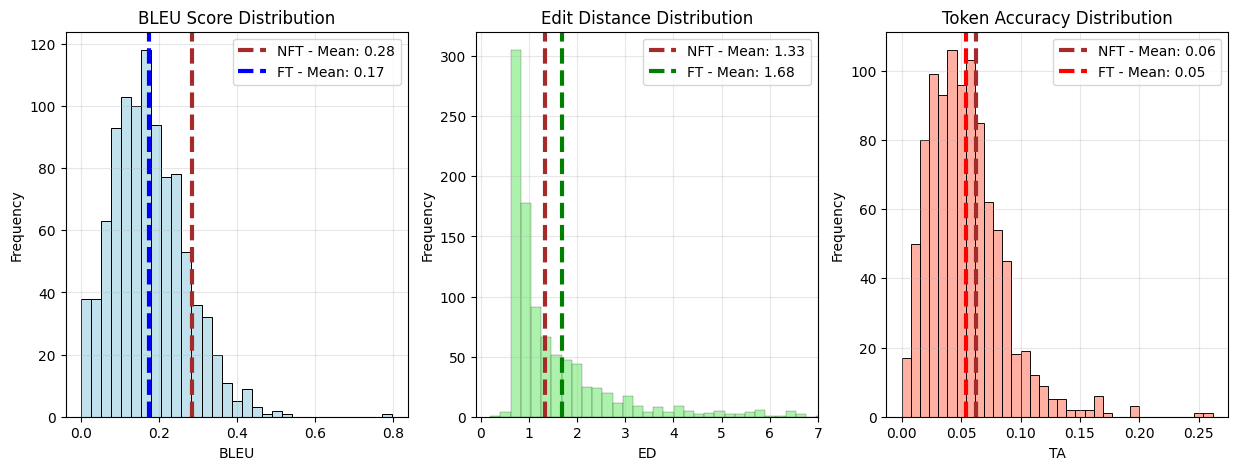

In [68]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.histplot(results["bleu_list"], ax=ax[0], color="lightblue")
ax[0].set_title("BLEU Score Distribution")
ax[0].axvline(np.mean(results_no_ft["bleu_score"]), color="brown", linestyle="--", lw=3, label="NFT - Mean: {:.2f}".format(np.mean(results_no_ft["bleu_score"])))
ax[0].axvline(np.mean(results["bleu_score"]), color="blue", linestyle="--", lw=3, label="FT - Mean: {:.2f}".format(np.mean(results["bleu_score"])))
ax[0].legend()


sns.histplot(results["edit_dists_list"], ax=ax[1], color="lightgreen")
ax[1].set_title("Edit Distance Distribution")
ax[1].set_xlim([-.1, 7])
ax[1].axvline(np.mean(results_no_ft["edit_distance"]), color="brown", linestyle="--", lw=3, label="NFT - Mean: {:.2f}".format(np.mean(results_no_ft["edit_distance"])))
ax[1].axvline(np.mean(results["edit_distance"]), color="green", linestyle="--", lw=3, label="FT - Mean: {:.2f}".format(np.mean(results["edit_distance"])))
ax[1].legend()

sns.histplot(results["token_acc_list"], ax=ax[2], color="tomato", alpha=.5)
ax[2].set_title("Token Accuracy Distribution")
ax[2].axvline(np.mean(results_no_ft["token_accuracy"]), color="brown", linestyle="--", lw=3, label="NFT - Mean: {:.2f}".format(np.mean(results_no_ft["token_accuracy"])))
ax[2].axvline(np.mean(results["token_accuracy"]), color="red", linestyle="--", lw=3, label="FT - Mean: {:.2f}".format(np.mean(results["token_accuracy"])))
ax[2].legend()


for sax, metric in zip(ax, ["BLEU", "ED", "TA"]):
    sax.set_xlabel(metric)
    sax.set_ylabel("Frequency")
    sax.grid(True, alpha=.3)

# Can we recover bounding boxes from the trained model?

In [76]:
import cv2
from PIL import Image

# read image
im = cv2.imread("pix2tex/dataset/multiline/test_resized/0.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = ml_dataset_test.transform(image=im)["image"][:1]

im


tensor([[[1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904],
         [1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904],
         [1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904],
         ...,
         [1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904],
         [1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904],
         [1.1904, 1.1904, 1.1904,  ..., 1.1904, 1.1904, 1.1904]]])

In [87]:
rep = ml_model.encoder(im.unsqueeze(0).to(device="mps:0"))

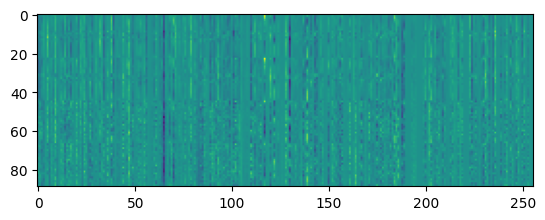

In [91]:
plt.imshow(rep.squeeze().cpu().detach().numpy())